<a href="https://colab.research.google.com/github/GrImReApEr-1470/RDOA-comparative-analysis/blob/main/RDOA_comparative_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [ ]:
import numpy as np
from copy import deepcopy
from random import random, randint
import matplotlib.pyplot as plt

#Benchmark problems (fitness functions)

In [ ]:
def sphere(solution=None, problem_size=None):
    problem_size = len(solution)
    return np.sum(solution**2)

def rosenbrock(solution=None, problem_size=None):
    problem_size = len(solution)
    return sum(100.0*(solution[1:]-solution[:-1]**2.0)**2.0 + (1-solution[:-1])**2.0)

def bohachevsky(solution=None, problem_size=None):
    problem_size = len(solution)
    x, y = solution[0], solution[1]
    return x**2 + 2 * y**2 - 0.3 * np.cos(3 * np.pi * x) - 0.4 * np.cos(4 * np.pi * y) + 0.7

def griewank(solution=None, problem_size=None):
    problem_size = len(solution)
    sum1 = np.sum(solution**2)
    prod1 = np.prod(np.cos(solution / np.sqrt(np.arange(1, problem_size + 1))))
    return 1 + sum1 / 4000 - prod1

def rastrigin(solution=None, problem_size=None):
    problem_size = len(solution)
    return 10 * problem_size + np.sum(solution**2 - 10 * np.cos(2 * np.pi * solution))

def eggholder(solution=None, problem_size=None):
    problem_size = len(solution)
    if solution is None:
        return None
    n = len(solution)

    if n < 2:
        raise ValueError("The Eggholder function requires at least 2 dimensions.")

    result = 0
    for i in range(n - 1):
        xi = solution[i]
        xi1 = solution[i + 1]
        term1 = -(xi1 + 47) * np.sin(np.sqrt(abs(xi1 + xi / 2 + 47)))
        term2 = -xi * np.sin(np.sqrt(abs(xi - (xi1 + 47))))
        result += term1 + term2

    return result

#Algorithm definitions for each algorithm


// code taken from https://github.com/thieu1995/metaheuristics

##Base Class

In [ ]:
class RootAlgo(object):
    """ This is root of all Algorithms """
    ID_MIN_PROBLEM = 0
    ID_MAX_PROBLEM = -1

    def __init__(self, root_algo_paras=None):
        self.problem_size = root_algo_paras["problem_size"]
        self.domain_range = root_algo_paras["domain_range"]
        self.print_train = root_algo_paras["print_train"]
        self.objective_func = root_algo_paras["objective_func"]
        self.solution, self.loss_train = None, []

    def _create_solution__(self, minmax=0):
        solution = np.random.uniform(
            self.domain_range[0], self.domain_range[1], self.problem_size)
        fitness = self._fitness_model__(solution=solution, minmax=minmax)
        return [solution, fitness]

    def _fitness_model__(self, solution=None, minmax=0):
        """ Assumption that objective function always return the original value """
        return self.objective_func(solution, self.problem_size) if minmax == 0 \
            else 1.0 / self.objective_func(solution, self.problem_size)

    def _fitness_encoded__(self, encoded=None, id_pos=None, minmax=0):
        return self._fitness_model__(solution=encoded[id_pos], minmax=minmax)

    def _get_global_best__(self, pop=None, id_fitness=None, id_best=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fitness])
        return deepcopy(sorted_pop[id_best])

    def _get_global_worst__(self, pop=None, id_fitness=None, id_worst=None):
        sorted_pop = sorted(pop, key=lambda temp: temp[id_fitness])
        return deepcopy(sorted_pop[id_worst])

    def _amend_solution__(self, solution=None):
        for i in range(self.problem_size):
            if solution[i] < self.domain_range[0]:
                solution[i] = self.domain_range[0]
            if solution[i] > self.domain_range[1]:
                solution[i] = self.domain_range[1]

    def _amend_solution_and_return__(self, solution=None):
        for i in range(self.problem_size):
            if solution[i] < self.domain_range[0]:
                solution[i] = self.domain_range[0]
            if solution[i] > self.domain_range[1]:
                solution[i] = self.domain_range[1]
        return solution

    def _create_opposition_solution__(self, solution=None, g_best=None):
        temp = [self.domain_range[0] + self.domain_range[1] - g_best[i] + np.random.random() * (g_best[i] - solution[i])
                for i in range(self.problem_size)]
        return np.array(temp)

    def _train__(self):
        pass

##Genetic


In [ ]:
class BaseGA(RootAlgo):
    """
    Link:
        https://blog.sicara.com/getting-started-genetic-algorithms-python-tutorial-81ffa1dd72f9
        https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_quick_guide.htm
        https://www.analyticsvidhya.com/blog/2017/07/introduction-to-genetic-algorithm/
    """
    ID_FITNESS = 1

    def __init__(self, root_algo_paras=None, ga_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = ga_paras["epoch"]
        self.pop_size = ga_paras["pop_size"]
        self.pc = ga_paras["pc"]
        self.pm = ga_paras["pm"]

    ### Selection
    def _get_index_roulette_wheel_selection__(self, list_fitness, sum_fitness):
        r = np.random.uniform(low=0, high=sum_fitness)
        for idx, f in enumerate(list_fitness):
            r = r + f
            if r > sum_fitness:
                return idx

    ### Crossover
    def _crossover_arthmetic_recombination__(self, dad=None, mom=None):
        r = np.random.uniform()             # w1 = w2 when r =0.5
        w1 = np.multiply(r, dad) + np.multiply((1 - r), mom)
        w2 = np.multiply(r, mom) + np.multiply((1 - r), dad)
        return w1, w2

    ### Mutation
    def _mutation_flip_point__(self, parent, index):
        w = deepcopy(parent)
        w[index] = np.random.uniform(
            self.domain_range[0], self.domain_range[1])
        return w

    def _create_next_generation__(self, pop):
        next_population = []

        list_fitness = [pop[i][self.ID_FITNESS] for i in range(self.pop_size)]
        fitness_sum = sum(list_fitness)
        while (len(next_population) < self.pop_size):
            ### Selection
            c1 = deepcopy(
                pop[self._get_index_roulette_wheel_selection__(list_fitness, fitness_sum)])
            c2 = deepcopy(
                pop[self._get_index_roulette_wheel_selection__(list_fitness, fitness_sum)])

            w1, w2 = deepcopy(c1[0]), deepcopy(c2[0])
            ### Crossover
            if np.random.uniform() < self.pc:
                w1, w2 = self._crossover_arthmetic_recombination__(
                    c1[0], c2[0])

            ### Mutation
            for id in range(0, self.problem_size):
                if np.random.uniform() < self.pm:
                    w1 = self._mutation_flip_point__(w1, id)
                if np.random.uniform() < self.pm:
                    w2 = self._mutation_flip_point__(w2, id)

            c1_new = [deepcopy(w1), self._fitness_model__(w1, minmax=1)]
            c2_new = [deepcopy(w2), self._fitness_model__(w2, minmax=1)]
            next_population.append(c1_new)
            next_population.append(c2_new)
        return next_population

    def _train__(self):
        best_train = [None, -1]
        pop = [self._create_solution__(minmax=1) for _ in range(self.pop_size)]

        for j in range(0, self.epoch):
            # Next generations
            pop = deepcopy(self._create_next_generation__(pop))
            current_best = self._get_global_best__(
                pop=pop, id_fitness=self.ID_FITNESS, id_best=self.ID_MAX_PROBLEM)
            if current_best[self.ID_FITNESS] > best_train[self.ID_FITNESS]:
                best_train = current_best
            if self.print_train:
                print("> Epoch {0}: Best training fitness {1}".format(
                    j + 1, 1.0 / best_train[self.ID_FITNESS]))
            self.loss_train.append(np.power(best_train[self.ID_FITNESS], -1))

        return best_train[0], self.loss_train

##PSO

In [ ]:
class BasePSO(RootAlgo):
    """
    Particle Swarm Optimization
    """
    ID_CURRENT_POS = 0
    ID_BEST_PAST_POS = 1
    ID_VECTOR_V = 2
    ID_CURRENT_FIT = 3
    ID_PAST_FIT = 4

    def __init__(self, root_algo_paras=None, pso_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = pso_paras["epoch"]
        self.pop_size = pso_paras["pop_size"]
        self.c1 = pso_paras["c_minmax"][0]
        self.c2 = pso_paras["c_minmax"][1]
        self.w_min = pso_paras["w_minmax"][0]
        self.w_max = pso_paras["w_minmax"][1]

    def _create_solution__(self, minmax=0):
        """  This algorithm has different encoding mechanism, so we need to override this method
                x: current position
                x_past_best: the best personal position so far (in history)
                v: velocity of this bird (same number of dimension of x)
        """
        x = np.random.uniform(self.domain_range[0], self.domain_range[1], self.problem_size)
        x_past_best = deepcopy(x)
        v = np.zeros(len(x))
        x_fitness = self._fitness_model__(solution=x, minmax=minmax)
        x_past_fitness = deepcopy(x_fitness)
        return [x, x_past_best, v, x_fitness, x_past_fitness]

    def _train__(self):
        pop = [self._create_solution__(minmax=0) for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_CURRENT_FIT, id_best=self.ID_MIN_PROBLEM)

        for i in range(self.epoch):
            # Update weight after each move count  (weight down)
            w = (self.epoch - i) / self.epoch * (self.w_max - self.w_min) + self.w_min
            for j in range(self.pop_size):
                r1 = np.random.random_sample()
                r2 = np.random.random_sample()
                vi_sau = w * pop[j][self.ID_VECTOR_V] + self.c1 * r1 * \
                         (pop[j][self.ID_BEST_PAST_POS] - pop[j][self.ID_CURRENT_POS]) \
                         + self.c2 * r2 * (gbest[self.ID_CURRENT_POS] - pop[j][self.ID_CURRENT_POS])
                xi_sau = pop[j][self.ID_CURRENT_POS] + vi_sau                 # Xi(sau) = Xi(truoc) + Vi(sau) * deltaT (deltaT = 1)
                fit_sau = self._fitness_model__(solution=xi_sau, minmax=0)
                fit_truoc = pop[j][self.ID_PAST_FIT]

                # Update current position, current vector v
                pop[j][self.ID_CURRENT_POS] = deepcopy(xi_sau)
                pop[j][self.ID_VECTOR_V] = deepcopy(vi_sau)
                pop[j][self.ID_CURRENT_FIT] = fit_sau

                if fit_sau < fit_truoc:
                    pop[j][self.ID_BEST_PAST_POS] = deepcopy(xi_sau)
                    pop[j][self.ID_PAST_FIT] = fit_sau

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_CURRENT_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_CURRENT_FIT] < gbest[self.ID_CURRENT_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_CURRENT_FIT])
            if self.print_train:
                print("Generation : {0}, best result so far: {1}".format(i+1, gbest[self.ID_CURRENT_FIT]))

        return gbest[self.ID_CURRENT_FIT], self.loss_train

##Differential Evolution

In [ ]:
class BaseDE(RootAlgo):
    """
    Differential Evolution : Taken from here
    http://www.cleveralgorithms.com/nature-inspired/evolution/differential_evolution.html
    """
    ID_SOl = 0
    ID_FIT = 1
    def __init__(self, root_algo_paras=None, de_paras = None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch =  de_paras["epoch"]
        self.pop_size = de_paras["pop_size"]
        self.weighting_factor = de_paras["Wf"]
        self.crossover_rate = de_paras["Cr"]

    def _mutation__(self, p0, p1, p2, p3):
        # Choose a cut point which differs 0 and chromosome-1 (first and last element)
        cut_point = np.random.randint(1, self.problem_size - 1)
        sample = []
        for i in range(self.problem_size):
            if i == cut_point or np.random.uniform() < self.crossover_rate  :
                v = p1[i] + self.weighting_factor * ( p2[i] - p3[i])
                v = self.domain_range[0] if v < self.domain_range[0] else v
                v = self.domain_range[1] if v > self.domain_range[1] else v
                sample.append(v)
            else :
                sample.append(p0[i])
        return np.array(sample)

    def _create_children__(self, pop):
        new_children = []
        for i in range(self.pop_size):
            temp = np.random.choice(range(0, self.pop_size), 3, replace=False)
            while i in temp:
                temp = np.random.choice(range(0, self.pop_size), 3, replace=False)
            #create new child and append in children array
            child = self._mutation__(pop[i][self.ID_SOl], pop[temp[0]][self.ID_SOl], pop[temp[1]][self.ID_SOl], pop[temp[2]][self.ID_SOl])
            fit = self._fitness_model__(child)
            new_children.append([child, fit])
        return np.array(new_children)

    ### Survivor Selection
    def _greedy_selection__(self, pop_old=None, pop_new=None):
        pop = [pop_new[i] if pop_new[i][self.ID_FIT] < pop_old[i][self.ID_FIT]
               else pop_old[i] for i in range(self.pop_size)]
        return pop

    def _train__(self):
        pop = [self._create_solution__() for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)

        for i in range(self.epoch):
            # create children
            children = self._create_children__(pop)
            # create new pop by comparing fitness of corresponding each member in pop and children
            pop = self._greedy_selection__(pop, children)

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT]< gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch : {}, [MSE, MAE]: {}".format(i + 1, gbest[self.ID_FIT]))

        return gbest[self.ID_SOl], self.loss_train

##Artificial Bee Colony

In [ ]:
class BaseABC(RootAlgo):
    """
    - Transformation from ruby code to python code in Clever Algorithms book
        - Improved function _create_neigh_bee__
        - Better results, faster convergence
    """
    ID_BEE = 0
    ID_FITNESS = 1

    def __init__(self, root_algo_paras=None, abc_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = abc_paras["epoch"]
        self.pop_size = abc_paras["pop_size"]
        self.e_bees = abc_paras["couple_bees"][0]
        self.o_bees = abc_paras["couple_bees"][1]

        self.patch_size = abc_paras["patch_variables"][0]
        self.patch_factor = abc_paras["patch_variables"][1]
        self.num_sites = abc_paras["sites"][0]
        self.elite_sites = abc_paras["sites"][1]

    def _create_neigh_bee__(self, individual=None, patch_size=None):
        t1 = randint(0, len(individual) - 1)
        new_bee = deepcopy(individual)
        new_bee[t1] = (individual[t1] + random() * patch_size) if random() < 0.5 else (individual[t1] - random() * patch_size)
        if random() < 0.5:
            new_bee[t1] = individual[t1] + random() * patch_size
            if new_bee[t1] > self.domain_range[1]:
                new_bee[t1] = self.domain_range[1]
        else:
            new_bee[t1] = individual[t1] - random() * patch_size
            if new_bee[t1] < self.domain_range[0]:
                new_bee[t1] = self.domain_range[0]
        return [new_bee, self._fitness_model__(new_bee)]


    def _search_neigh__(self, parent=None, neigh_size=None):  # parent:  [ vector_individual, fitness ]
        """
        Seeking in neigh_size neighborhood, take the best
        """
        neigh = [self._create_neigh_bee__(parent[0], self.patch_size) for _ in range(0, neigh_size)]
        return self._get_global_best__(neigh, self.ID_FITNESS, self.ID_MIN_PROBLEM)

    def _create_scout_bees__(self, num_scouts=None):  # So luong ong trinh tham
        return [self._create_solution__() for _ in range(0, num_scouts)]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(0, self.pop_size)]
        for j in range(0, self.epoch):
            pop_sorted = sorted(pop, key=lambda bee: bee[self.ID_FITNESS])
            best = deepcopy(pop_sorted[self.ID_MIN_PROBLEM])

            next_gen = []
            for i in range(0, self.num_sites):
                if i < self.elite_sites:
                    neigh_size = self.e_bees
                else:
                    neigh_size = self.o_bees
                next_gen.append(self._search_neigh__(pop_sorted[i], neigh_size))

            scouts = self._create_scout_bees__(self.pop_size - self.num_sites)  # Ong trinh tham
            pop = next_gen + scouts
            self.patch_size = self.patch_size * self.patch_factor
            self.loss_train.append(best[self.ID_FITNESS])
            if self.print_train:
                print("Epoch = {}, patch_size = {}, Fit = {}".format(j + 1, self.patch_size, best[self.ID_FITNESS]))

        best = self._get_global_best__(pop, self.ID_FITNESS, self.ID_MIN_PROBLEM)
        return best[self.ID_BEE], self.loss_train

##Whale Optimization algorithm

In [ ]:
class BaseWOA(RootAlgo):
    """
    Standard version of Whale Optimization Algorithm (belongs to Swarm-based Algorithms)
    - In this algorithms: Prey means the best solution
    """
    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, woa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = woa_paras["epoch"]
        self.pop_size = woa_paras["pop_size"]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
        # Find prey which is the best solution

        for i in range(self.epoch):
            a = 2 - 2 * i / (self.epoch - 1)            # linearly decreased from 2 to 0

            for j in range(self.pop_size):

                r = np.random.rand()
                A = 2 * a * r - a
                C = 2 * r
                l = np.random.uniform(-1, 1)
                p = 0.5
                b = 1
                if (np.random.uniform() < p) :
                    if np.abs(A) < 1:
                        D = np.abs(C * gbest[self.ID_POS] - pop[j][self.ID_POS] )
                        new_position = gbest[0] - A * D
                    else :
                        #x_rand = pop[np.random.randint(self.pop_size)] # chon ra 1 thang random
                        x_rand = self._create_solution__()
                        D = np.abs(C * x_rand[self.ID_POS] - pop[j][self.ID_POS])
                        new_position = (x_rand[self.ID_POS] - A * D)
                else:
                    D1 = np.abs(gbest[0] - pop[j][0])
                    new_position = D1 * np.exp(b * l) * np.cos(2 * np.pi * l) + gbest[self.ID_POS]

                new_position[new_position < self.domain_range[0]] = self.domain_range[0]
                new_position[new_position > self.domain_range[1]] = self.domain_range[1]
                fit = self._fitness_model__(new_position)
                pop[j] = [new_position, fit]

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT] < gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch = {}, Best fit so far = {}".format(i + 1, gbest[self.ID_FIT]))

        return gbest[self.ID_POS], self.loss_train



class BaoWOA(RootAlgo):
    """
    Code of Bao
    """
    ID_POS = 0
    ID_FIT = 1

    def __init__(self, root_algo_paras=None, woa_paras=None):
        RootAlgo.__init__(self, root_algo_paras)
        self.epoch = woa_paras["epoch"]
        self.pop_size = woa_paras["pop_size"]

    def _train__(self):
        pop = [self._create_solution__() for _ in range(self.pop_size)]
        gbest = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)   # Find prey which is the best solution

        for i in range(self.epoch):
            a = 2 - 2 * i / (self.epoch - 1)            # linearly decreased from 2 to 0

            for j in range(self.pop_size):

                r = np.random.rand()
                A = 2 * a * r - a
                C = 2 * r
                l = np.random.uniform(-1, 1)
                p = np.random.rand()
                b = 1

                if (p < 0.5) :
                    if np.abs(A) < 1:
                        D = np.abs(C * gbest[self.ID_POS] - pop[j][self.ID_POS] )
                        new_position = gbest[0] - A * D
                    else :
                        x_rand = pop[np.random.randint(self.pop_size)] # chon ra 1 thang random
                        D = np.abs(C * x_rand[self.ID_POS] - pop[j][self.ID_POS])
                        new_position = (x_rand[self.ID_POS] - A * D)
                else:
                    D1 = np.abs(gbest[0] - pop[j][0])
                    new_position = D1 * np.exp(b * l) * np.cos(2 * np.pi * l) + gbest[self.ID_POS]
                new_position = self._amend_solution_and_return__(new_position)
                fit = self._fitness_model__(new_position)
                pop[j] = [new_position, fit]

            current_best = self._get_global_best__(pop=pop, id_fitness=self.ID_FIT, id_best=self.ID_MIN_PROBLEM)
            if current_best[self.ID_FIT] < gbest[self.ID_FIT]:
                gbest = deepcopy(current_best)
            self.loss_train.append(gbest[self.ID_FIT])
            if self.print_train:
                print("Epoch = {}, Fit = {}".format(i + 1, gbest[self.ID_FIT]))
        #print(gbest[self.ID_POS])
        return gbest[self.ID_FIT], self.loss_train

##Red Deer Optimization

In [ ]:
# Define the Roar function
def Roar(x, VarMin, VarMax):
    nVar = len(x)
    a = np.random.rand()
    b = np.random.rand()
    c = np.random.rand()
    nmu = int(np.ceil(a * nVar))
    Sig = b * (VarMax - VarMin)
    Sig2 = a * (Sig + VarMin)
    y = x.copy()
    if c >= 0.5:
        j = np.random.choice(nVar, nmu)
        y[j] = x[j] + (Sig2 * np.random.randn(len(j)))
    else:
        j = np.random.choice(nVar, nmu)
        y[j] = x[j] - (Sig2 * np.random.randn(len(j)))
    y = np.maximum(y, VarMin)
    y = np.minimum(y, VarMax)
    return y


def Fight(x1, x2, VarMin, VarMax):
    a = np.random.rand()
    b = np.random.rand()

    Sig = b * (VarMax - VarMin)
    Sig2 = a * (Sig + VarMin)
    zetta = (x1 + x2) / 2

    y1 = zetta - Sig2 + VarMin
    y2 = zetta + Sig2 + VarMin

    y1 = np.maximum(y1, VarMin)
    y1 = np.minimum(y1, VarMax)

    y2 = np.maximum(y2, VarMin)
    y2 = np.minimum(y2, VarMax)

    return y1, y2

# Define the Mate function
def Mate(x1, x2, VarMin, VarMax):
    b = np.random.rand()
    Sig = b * (VarMax - VarMin)
    zetta = (x1 + x2) / 2
    y1 = zetta + Sig
    y2 = zetta - Sig
    y1 = np.maximum(y1, VarMin)
    y1 = np.minimum(y1, VarMax)
    y2 = np.maximum(y2, VarMin)
    y2 = np.minimum(y2, VarMax)
    return y1, y2

# Define the RouletteWheelSelection function
def RouletteWheelSelection(P):
    r = np.random.rand()
    c = np.cumsum(P)
    i = np.where(r <= c)[0][0]
    return i

# # Define the Sphere function (you should define your CostFunction similarly)
# def Sphere(x):
#     return np.sum(x**2)


def RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax):
    nHinds = nPop - nMaleRD
    VarSize = (1, nVar)
    # Initialization
    empty_reddeer = {'Position': None, 'Cost': None}
    nTotal = round(nHinds * (alpha + betta)) + nMaleRD
    reddeer = [empty_reddeer.copy() for _ in range(2 * nTotal)]
    reddeerT = [empty_reddeer.copy() for _ in range(2 * nTotal + nPop)]
    RD = [empty_reddeer.copy() for _ in range(nPop)]

    for i in range(2 * nTotal):
        reddeer[i]['Position'] = np.random.uniform(VarMin, VarMax, VarSize)
        reddeer[i]['Cost'] = CostFunction(reddeer[i]['Position'][0])

    for i in range(nPop):
        RD[i]['Position'] = np.random.uniform(VarMin, VarMax, VarSize)
        RD[i]['Cost'] = CostFunction(RD[i]['Position'][0])

    costs = [rd['Cost'] for rd in RD]
    SortOrder = np.argsort(costs)
    RD = [RD[i] for i in SortOrder]

    MaleRD = RD[:nMaleRD]
    MaleRDN = list(MaleRD)
    Hinds = RD[nMaleRD:]

    # Define empty_hrms
    empty_hrms = {'MaleRD': None, 'Hinds': [], 'nHinds': 0}

    # BestSol initialization
    BestSol = MaleRD[0]
    BestCost = np.zeros(MaxIt)
    MeanCost = np.zeros(MaxIt)
    F = np.zeros(1)
    Z = np.zeros(1)
    G = np.zeros(4)
    T = np.zeros((4, nVar))
    S = np.zeros(nHinds)

    it = 0
    convergence = np.zeros(MaxIt+1)

    # Main Loop
    while it < MaxIt:
        F[0] = 0
        Z[0] = 0

        # Roaring
        for j in range(nMaleRD):
            p = MaleRD[j]
            MaleRDN[j]['Position'] = Roar(p['Position'], VarMin, VarMax)
            MaleRDN[j]['Cost'] = CostFunction(MaleRDN[j]['Position'][0])

            if MaleRD[j]['Cost'] > MaleRDN[j]['Cost']:
                MaleRD[j] = MaleRDN[j]

        # Select gamma percent of males to be commanders

        nstag = nMaleRD - round(nMaleRD * gamma)
        nMaleRD = round(nMaleRD * gamma)
        costs = [MaleRD[i]['Cost'] for i in range(len(MaleRD))]
        SortOrder = np.argsort(costs)
        MaleRD = [MaleRD[i] for i in SortOrder]
        stag = MaleRD[nMaleRD:]
        MaleRD = MaleRD[:nMaleRD]
        # print(len(stag))


        # Fighting
        for j in range(nMaleRD):
            w = randint(0, nstag - 1)
            p1 = MaleRD[j]
            p2 = stag[w]
            MaleRDN[j]['Position'], MaleRDN[w]['Position'] = Fight(p1['Position'], p2['Position'], VarMin, VarMax)
            MaleRDN[j]['Cost'] = CostFunction(MaleRDN[j]['Position'][0])
            MaleRDN[w]['Cost'] = CostFunction(MaleRDN[w]['Position'][0])
            G = [MaleRD[j]['Cost'], stag[w]['Cost'], MaleRDN[j]['Cost'], MaleRDN[w]['Cost']]
            T = [MaleRD[j]['Position'], stag[w]['Position'], MaleRDN[j]['Position'], MaleRDN[w]['Position']]
            pos = np.argmin(G)
            MaleRD[j]['Cost'] = G[pos]
            MaleRD[j]['Position'] = T[pos]

        # Form harems
        hrms = [empty_hrms.copy() for _ in range(nMaleRD)]

        for i in range(nMaleRD):
            if BestSol['Cost'] > 0:
                hrms[i]['nHinds'] = 0
                hrms[i]['MaleRD'] = None
                hrms[i]['Hinds'] = []
            else:
                break

        for k in range(nMaleRD):
            hrms[k]['MaleRD'] = MaleRD[k]

        # Assign Harems
        P = np.exp(-random() * np.array([MaleRD[i]['Cost'] for i in range(nMaleRD)]) / max(
            [MaleRD[i]['Cost'] for i in range(nMaleRD)]))
        P = P / np.sum(P)


        for j in range(nHinds):
            if BestSol['Cost'] > 0:
                k = RouletteWheelSelection(P)
                hrms[k]['Hinds'].append(Hinds[j])
                hrms[k]['nHinds'] += 1
            else:
                break

        # Starting breeding season
        for b in range(nMaleRD):
            P1 = MaleRD[b]

            if round(hrms[b]['nHinds'] * alpha) > 0:
                F[0] += round(hrms[b]['nHinds'] * alpha)
                for j in range(round(hrms[b]['nHinds'] * alpha)):
                    P2 = hrms[b]['Hinds'][j]
                    reddeer[int(F[0] + j - round(hrms[b]['nHinds'] * alpha))]['Position'], \
                    reddeer[int(nTotal + F[0] - round(hrms[b]['nHinds'] * alpha)) + j]['Position'] = \
                        Mate(P1['Position'], P2['Position'], VarMin, VarMax)
                    reddeer[int(F[0] + j - round(hrms[b]['nHinds'] * alpha))]['Cost'] = CostFunction(
                        reddeer[int(F[0] + j - round(hrms[b]['nHinds'] * alpha))]['Position'][0])
                    reddeer[int(nTotal + F[0] + j - round(hrms[b]['nHinds'] * alpha))]['Cost'] = CostFunction(
                        reddeer[int(nTotal + F[0] + j - round(hrms[b]['nHinds'] * alpha))]['Position'][0])

        for b in range(nMaleRD):
            t = randint(0, nMaleRD - 1)

            if round(hrms[t]['nHinds']) > 0:
                # Z[0] += round(hrms[t]['nHinds'] * betta)
                # for g in range(round(hrms[t]['nHinds'] * betta)):
                #     S2 = hrms[t]['Hinds'][g]
                #     reddeer[round((nHinds) * alpha) +
                Z[0] += round(hrms[t]['nHinds'] * betta)
                for g in range(round(hrms[t]['nHinds'] * betta)):
                    S2 = hrms[t]['Hinds'][g]
                    reddeer[int(round((nHinds) * alpha) + Z[0] + g - round(hrms[t]['nHinds'] * betta))]['Position'], \
                    reddeer[int(nTotal + round((nHinds) * alpha) + Z[0] + g - round(hrms[t]['nHinds'] * betta))]['Position'] = \
                        Mate(P1['Position'], S2['Position'], VarMin, VarMax)
                    reddeer[int(round((nHinds) * alpha) + Z[0] + g - round(hrms[t]['nHinds'] * betta))]['Cost'] = CostFunction(
                        reddeer[int(round((nHinds) * alpha) + Z[0] + g - round(hrms[t]['nHinds'] * betta))]['Position'][0])
                    reddeer[int(nTotal + round((nHinds) * alpha) + Z[0] + g - round(hrms[t]['nHinds'] * betta))]['Cost'] = CostFunction(
                        reddeer[int(nTotal + round((nHinds) * alpha) + Z[0] + g - round(hrms[t]['nHinds'] * betta))]['Position'][0])

        # Top between the male commander of harem and nearest hind
        for b in range(nstag):
            P1 = stag[b]
            S = np.zeros(nHinds)

            for j in range(nHinds):
                S[j] = np.sqrt(np.sum((stag[b]['Position'] - Hinds[j]['Position']) ** 2))

            pos = np.argmin(S)
            C2 = Hinds[pos]

            reddeer[int(round(nHinds * (alpha + betta)) + b)]['Position'], \
            reddeer[int(nTotal + round(nHinds * (alpha + betta)) + b)]['Position'] = \
                Mate(P1['Position'], C2['Position'], VarMin, VarMax)
            reddeer[int(round(nHinds * (alpha + betta)) + b)]['Cost'] = CostFunction(
                reddeer[int(round(nHinds * (alpha + betta)) + b)]['Position'][0])
            reddeer[int(nTotal + round(nHinds * (alpha + betta)) + b)]['Cost'] = CostFunction(
                reddeer[int(nTotal + round(nHinds * (alpha + betta)) + b)]['Position'][0])
        # print(type(reddeer[0]))
        # reddeer = [rd for sublist in reddeer for rd in sublist]
        nMaleRD = nstag + nMaleRD

        # Select the best reddeers
        reddeerT = MaleRD + Hinds + reddeer
        # print(reddeerT)
        # for rd in reddeerT:
        #     print(rd['Cost'])
        # print(type(reddeer[0]))
        CostTotal = [rd['Cost'] for rd in reddeerT]
        SortOrder = np.argsort(CostTotal)
        reddeerT = [reddeerT[i] for i in SortOrder]
        BestSol = reddeerT[0]
        BestCost[it] = BestSol['Cost']
        if it==0: convergence[0] = BestCost[0]
        convergence[it+1] = min(convergence[it], BestCost[it])
        MeanCost[it] = np.mean(CostTotal)
        # print(f'Iteration {it + 1}: Best Cost = {BestCost[it]:.6f} : Mean Cost = {MeanCost[it]:.6f}')
        # print(f'Iteration {it + 1}: Best Cost = {convergence[it]}')

        # Select the next generation
        MaleRD = reddeerT[:nMaleRD]
        reddeerT = reddeerT[nMaleRD:]
        P1 = np.exp(-random() * np.array([rd['Cost'] for rd in reddeerT]) / max(
            [rd['Cost'] for rd in reddeerT]))
        P1 = P1 / np.sum(P1)


        for j in range(nHinds):
            k = RouletteWheelSelection(P1)
            Hinds[j] = reddeerT[k]

        it += 1

    # Plot results
    # plt.figure()
    # plt.semilogy(convergence, 'b', linewidth=2, label='Minimum Cost')
    # # plt.semilogy(MeanCost, 'r:', linewidth=2, label='Mean Cost')
    # plt.legend()
    # plt.xlabel('Iteration')
    # plt.ylabel('Cost')
    # plt.show()
    return convergence[1:]


# # Problem Definition
# CostFunction = Sphere
# nVar = 100
# VarMin, VarMax = -50, 50

# # RDA parameters
# MaxIt = 1000
# nPop = 50
# nMaleRD = 15
# alpha = 0.8
# betta = 0.2
# gamma = 0.2
# RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

#Compare the algorithms

In [ ]:
ga_loss_train = [[]for i in range(6)]
pso_loss_train = [[]for i in range(6)]
de_loss_train = [[]for i in range(6)]
abc_loss_train = [[]for i in range(6)]
woa_loss_train = [[]for i in range(6)]
rda_loss_train = [[]for i in range(6)]


##Sphere

In [ ]:


# Problem Definition
CostFunction = sphere
nVar = 100
VarMin, VarMax = -100, 100
root_paras = {
    "problem_size": nVar,
    "domain_range": [VarMin, VarMax],
    "print_train": False,
    "objective_func": CostFunction
}

# RDA parameters
MaxIt = 500

maxIt = MaxIt
nPop = 100
nMaleRD = 15
alpha = 0.8
betta = 0.2
gamma = 0.2

# GA parameters
ga_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "pc": 0.9,
    "pm": 0.005
}

# PSO parameters
pso_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "w_minmax": [0.4, 0.9],     # [0-1] -> [0.4-0.9]      Weight of bird
    "c_minmax": [1.2, 1.2]      # [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Effecting of  local va global
}

# DE parameters
de_paras = {
    "epoch": MaxIt,
    "pop_size": 20,
    "Wf": 0.5,
    "Cr": 0.7
}

# ABC parameters
abc_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "couple_bees": [100, 20],               # number of bees which provided for good location and other location
    "patch_variables": [1000.0, 0.99],        # patch_variables = patch_variables * patch_factor (0.99999)
    "sites": [20, 4],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
}

# WOA parameters
woa_paras = {
    "epoch": MaxIt,
    "pop_size": 100
}

md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
best_solution, ga_loss_train[0] = md._train__()

md = BasePSO(root_algo_paras=root_paras, pso_paras=pso_paras)
best_solution, pso_loss_train[0] = md._train__()

md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
best_solution, de_loss_train[0] = md._train__()

md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
best_solution, abc_loss_train[0] = md._train__()

md = BaoWOA(root_algo_paras=root_paras, woa_paras=woa_paras)
best_solution, woa_loss_train[0] = md._train__()

rda_loss_train[0] = RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

# plt.figure()
# plt.plot(range(1, MaxIt + 1), ga_loss_train[0], label="GA")
# plt.plot(range(1, MaxIt + 1), pso_loss_train[0], label="PSO")
# plt.plot(range(1, MaxIt + 1), de_loss_train[0], label="DE")
# plt.plot(range(1, MaxIt + 1), abc_loss_train[0], label="ABC")
# plt.plot(range(1, MaxIt + 1), woa_loss_train[0], label="PWOA")
# plt.plot(range(1, MaxIt + 1), rda_loss_train[0], label="RDA")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Convergence Curve - f1")
# plt.grid(True)
# plt.legend(loc="upper right")
# plt.show()

<ipython-input-6-0fc3ad2aa8b5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_children)


##rosenbrock

In [ ]:


# Problem Definition
CostFunction = rosenbrock
nVar = 100
VarMin, VarMax = -100, 100
root_paras = {
    "problem_size": nVar,
    "domain_range": [VarMin, VarMax],
    "print_train": False,
    "objective_func": CostFunction
}

# RDA parameters
MaxIt = 500

maxIt = MaxIt
nPop = 100
nMaleRD = 15
alpha = 0.8
betta = 0.2
gamma = 0.2

# GA parameters
ga_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "pc": 0.9,
    "pm": 0.005
}

# PSO parameters
pso_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "w_minmax": [0.4, 0.9],     # [0-1] -> [0.4-0.9]      Weight of bird
    "c_minmax": [1.2, 1.2]      # [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Effecting of  local va global
}

# DE parameters
de_paras = {
    "epoch": MaxIt,
    "pop_size": 20,
    "Wf": 0.5,
    "Cr": 0.7
}

# ABC parameters
abc_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "couple_bees": [100, 20],               # number of bees which provided for good location and other location
    "patch_variables": [1000.0, 0.99],        # patch_variables = patch_variables * patch_factor (0.99999)
    "sites": [20, 4],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
}

# WOA parameters
woa_paras = {
    "epoch": MaxIt,
    "pop_size": 100
}

md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
best_solution, ga_loss_train[1] = md._train__()

md = BasePSO(root_algo_paras=root_paras, pso_paras=pso_paras)
best_solution, pso_loss_train[1] = md._train__()

md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
best_solution, de_loss_train[1] = md._train__()

md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
best_solution, abc_loss_train[1] = md._train__()

md = BaoWOA(root_algo_paras=root_paras, woa_paras=woa_paras)
best_solution, woa_loss_train[1] = md._train__()

rda_loss_train[1] = RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

# plt.figure()
# plt.plot(range(1, MaxIt + 1), ga_loss_train[1], label="GA")
# plt.plot(range(1, MaxIt + 1), pso_loss_train[1], label="PSO")
# plt.plot(range(1, MaxIt + 1), de_loss_train[1], label="DE")
# plt.plot(range(1, MaxIt + 1), abc_loss_train[1], label="ABC")
# plt.plot(range(1, MaxIt + 1), woa_loss_train[1], label="PWOA")
# plt.plot(range(1, MaxIt + 1), rda_loss_train[1], label="RDA")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Convergence Curve - f1")
# plt.grid(True)
# plt.legend(loc="upper right")
# plt.show()

<ipython-input-6-0fc3ad2aa8b5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_children)


##bohachevsky

In [ ]:


# Problem Definition
CostFunction = bohachevsky
nVar = 100
VarMin, VarMax = -100, 100
root_paras = {
    "problem_size": nVar,
    "domain_range": [VarMin, VarMax],
    "print_train": False,
    "objective_func": CostFunction
}

# RDA parameters
MaxIt = 500

maxIt = MaxIt
nPop = 100
nMaleRD = 15
alpha = 0.8
betta = 0.2
gamma = 0.2

# GA parameters
ga_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "pc": 0.9,
    "pm": 0.005
}

# PSO parameters
pso_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "w_minmax": [0.4, 0.9],     # [0-1] -> [0.4-0.9]      Weight of bird
    "c_minmax": [1.2, 1.2]      # [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Effecting of  local va global
}

# DE parameters
de_paras = {
    "epoch": MaxIt,
    "pop_size": 20,
    "Wf": 0.5,
    "Cr": 0.7
}

# ABC parameters
abc_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "couple_bees": [100, 20],               # number of bees which provided for good location and other location
    "patch_variables": [1000.0, 0.99],        # patch_variables = patch_variables * patch_factor (0.99999)
    "sites": [20, 4],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
}

# WOA parameters
woa_paras = {
    "epoch": MaxIt,
    "pop_size": 100
}

md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
best_solution, ga_loss_train[2] = md._train__()

md = BasePSO(root_algo_paras=root_paras, pso_paras=pso_paras)
best_solution, pso_loss_train[2] = md._train__()

md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
best_solution, de_loss_train[2] = md._train__()

md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
best_solution, abc_loss_train[2] = md._train__()

md = BaoWOA(root_algo_paras=root_paras, woa_paras=woa_paras)
best_solution, woa_loss_train[2] = md._train__()

rda_loss_train[2] = RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

# plt.figure()
# plt.plot(range(1, MaxIt + 1), ga_loss_train[2], label="GA")
# plt.plot(range(1, MaxIt + 1), pso_loss_train[2], label="PSO")
# plt.plot(range(1, MaxIt + 1), de_loss_train[2], label="DE")
# plt.plot(range(1, MaxIt + 1), abc_loss_train[2], label="ABC")
# plt.plot(range(1, MaxIt + 1), woa_loss_train[2], label="PWOA")
# plt.plot(range(1, MaxIt + 1), rda_loss_train[2], label="RDA")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Convergence Curve - f1")
# plt.grid(True)
# plt.legend(loc="upper right")
# plt.show()

<ipython-input-6-0fc3ad2aa8b5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_children)


##griewank

In [ ]:


# Problem Definition
CostFunction = griewank
VarMin, VarMax = -100, 100
root_paras = {
    "problem_size": nVar,
    "domain_range": [VarMin, VarMax],
    "print_train": False,
    "objective_func": CostFunction
}

# RDA parameters
MaxIt = 500

maxIt = MaxIt
nPop = 100
nMaleRD = 15
alpha = 0.8
betta = 0.2
gamma = 0.2

# GA parameters
ga_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "pc": 0.9,
    "pm": 0.005
}

# PSO parameters
pso_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "w_minmax": [0.4, 0.9],     # [0-1] -> [0.4-0.9]      Weight of bird
    "c_minmax": [1.2, 1.2]      # [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Effecting of  local va global
}

# DE parameters
de_paras = {
    "epoch": MaxIt,
    "pop_size": 20,
    "Wf": 0.5,
    "Cr": 0.7
}

# ABC parameters
abc_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "couple_bees": [100, 20],               # number of bees which provided for good location and other location
    "patch_variables": [1000.0, 0.99],        # patch_variables = patch_variables * patch_factor (0.99999)
    "sites": [20, 4],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
}

# WOA parameters
woa_paras = {
    "epoch": MaxIt,
    "pop_size": 100
}

md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
best_solution, ga_loss_train[3] = md._train__()

md = BasePSO(root_algo_paras=root_paras, pso_paras=pso_paras)
best_solution, pso_loss_train[3] = md._train__()

md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
best_solution, de_loss_train[3] = md._train__()

md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
best_solution, abc_loss_train[3] = md._train__()

md = BaoWOA(root_algo_paras=root_paras, woa_paras=woa_paras)
best_solution, woa_loss_train[3] = md._train__()

rda_loss_train[3] = RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

# plt.figure()
# plt.plot(range(1, MaxIt + 1), ga_loss_train[3], label="GA")
# plt.plot(range(1, MaxIt + 1), pso_loss_train[3], label="PSO")
# plt.plot(range(1, MaxIt + 1), de_loss_train[3], label="DE")
# plt.plot(range(1, MaxIt + 1), abc_loss_train[3], label="ABC")
# plt.plot(range(1, MaxIt + 1), woa_loss_train[3], label="PWOA")
# plt.plot(range(1, MaxIt + 1), rda_loss_train[3], label="RDA")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Convergence Curve - f1")
# plt.grid(True)
# plt.legend(loc="upper right")
# plt.show()

<ipython-input-6-0fc3ad2aa8b5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_children)


##rastrigin

In [ ]:


# Problem Definition
CostFunction = rastrigin
nVar = 100
VarMin, VarMax = -100, 100
root_paras = {
    "problem_size": nVar,
    "domain_range": [VarMin, VarMax],
    "print_train": False,
    "objective_func": CostFunction
}

# RDA parameters
MaxIt = 500

maxIt = MaxIt
nPop = 100
nMaleRD = 15
alpha = 0.8
betta = 0.2
gamma = 0.2

# GA parameters
ga_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "pc": 0.9,
    "pm": 0.005
}

# PSO parameters
pso_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "w_minmax": [0.4, 0.9],     # [0-1] -> [0.4-0.9]      Weight of bird
    "c_minmax": [1.2, 1.2]      # [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Effecting of  local va global
}

# DE parameters
de_paras = {
    "epoch": MaxIt,
    "pop_size": 20,
    "Wf": 0.5,
    "Cr": 0.7
}

# ABC parameters
abc_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "couple_bees": [100, 20],               # number of bees which provided for good location and other location
    "patch_variables": [1000.0, 0.99],        # patch_variables = patch_variables * patch_factor (0.99999)
    "sites": [20, 4],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
}

# WOA parameters
woa_paras = {
    "epoch": MaxIt,
    "pop_size": 100
}

md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
best_solution, ga_loss_train[4] = md._train__()

md = BasePSO(root_algo_paras=root_paras, pso_paras=pso_paras)
best_solution, pso_loss_train[4] = md._train__()

md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
best_solution, de_loss_train[4] = md._train__()

md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
best_solution, abc_loss_train[4] = md._train__()

md = BaoWOA(root_algo_paras=root_paras, woa_paras=woa_paras)
best_solution, woa_loss_train[4] = md._train__()

rda_loss_train[4] = RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

# plt.figure()
# plt.plot(range(1, MaxIt + 1), ga_loss_train[4], label="GA")
# plt.plot(range(1, MaxIt + 1), pso_loss_train[4], label="PSO")
# plt.plot(range(1, MaxIt + 1), de_loss_train[4], label="DE")
# plt.plot(range(1, MaxIt + 1), abc_loss_train[4], label="ABC")
# plt.plot(range(1, MaxIt + 1), woa_loss_train[4], label="PWOA")
# plt.plot(range(1, MaxIt + 1), rda_loss_train[4], label="RDA")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Convergence Curve - f1")
# plt.grid(True)
# plt.legend(loc="upper right")
# plt.show()

<ipython-input-6-0fc3ad2aa8b5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_children)


##eggholder

In [ ]:


# Problem Definition
CostFunction = eggholder
nVar = 100
VarMin, VarMax = -100, 100
root_paras = {
    "problem_size": nVar,
    "domain_range": [VarMin, VarMax],
    "print_train": False,
    "objective_func": CostFunction
}

# RDA parameters
MaxIt = 500

maxIt = MaxIt
nPop = 100
nMaleRD = 15
alpha = 0.8
betta = 0.2
gamma = 0.2

# GA parameters
ga_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "pc": 0.9,
    "pm": 0.005
}

# PSO parameters
pso_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "w_minmax": [0.4, 0.9],     # [0-1] -> [0.4-0.9]      Weight of bird
    "c_minmax": [1.2, 1.2]      # [(1.2, 1.2), (0.8, 2.0), (1.6, 0.6)]  Effecting of  local va global
}

# DE parameters
de_paras = {
    "epoch": MaxIt,
    "pop_size": 20,
    "Wf": 0.5,
    "Cr": 0.7
}

# ABC parameters
abc_paras = {
    "epoch": MaxIt,
    "pop_size": 100,
    "couple_bees": [100, 20],               # number of bees which provided for good location and other location
    "patch_variables": [1000.0, 0.99],        # patch_variables = patch_variables * patch_factor (0.99999)
    "sites": [20, 4],                        # 3 bees (employed bees, onlookers and scouts), 1 good partition
}

# WOA parameters
woa_paras = {
    "epoch": MaxIt,
    "pop_size": 100
}

md = BaseGA(root_algo_paras=root_paras, ga_paras=ga_paras)
best_solution, ga_loss_train[5] = md._train__()

md = BasePSO(root_algo_paras=root_paras, pso_paras=pso_paras)
best_solution, pso_loss_train[5] = md._train__()

md = BaseDE(root_algo_paras=root_paras, de_paras=de_paras)
best_solution, de_loss_train[5] = md._train__()

md = BaseABC(root_algo_paras=root_paras, abc_paras=abc_paras)
best_solution, abc_loss_train[5] = md._train__()

md = BaoWOA(root_algo_paras=root_paras, woa_paras=woa_paras)
best_solution, woa_loss_train[5] = md._train__()

rda_loss_train[5] = RDA(MaxIt, nPop, nMaleRD, alpha, betta, gamma, CostFunction, nVar, VarMin, VarMax)

# plt.figure()
# plt.plot(range(1, MaxIt + 1), ga_loss_train[5], label="GA")
# plt.plot(range(1, MaxIt + 1), pso_loss_train[5], label="PSO")
# plt.plot(range(1, MaxIt + 1), de_loss_train[5], label="DE")
# plt.plot(range(1, MaxIt + 1), abc_loss_train[5], label="ABC")
# plt.plot(range(1, MaxIt + 1), woa_loss_train[5], label="PWOA")
# plt.plot(range(1, MaxIt + 1), rda_loss_train[5], label="RDA")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Convergence Curve - f1")
# plt.grid(True)
# plt.legend(loc="upper right")
# plt.show()

<ipython-input-6-0fc3ad2aa8b5>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_children)


#Final Convergence graphs

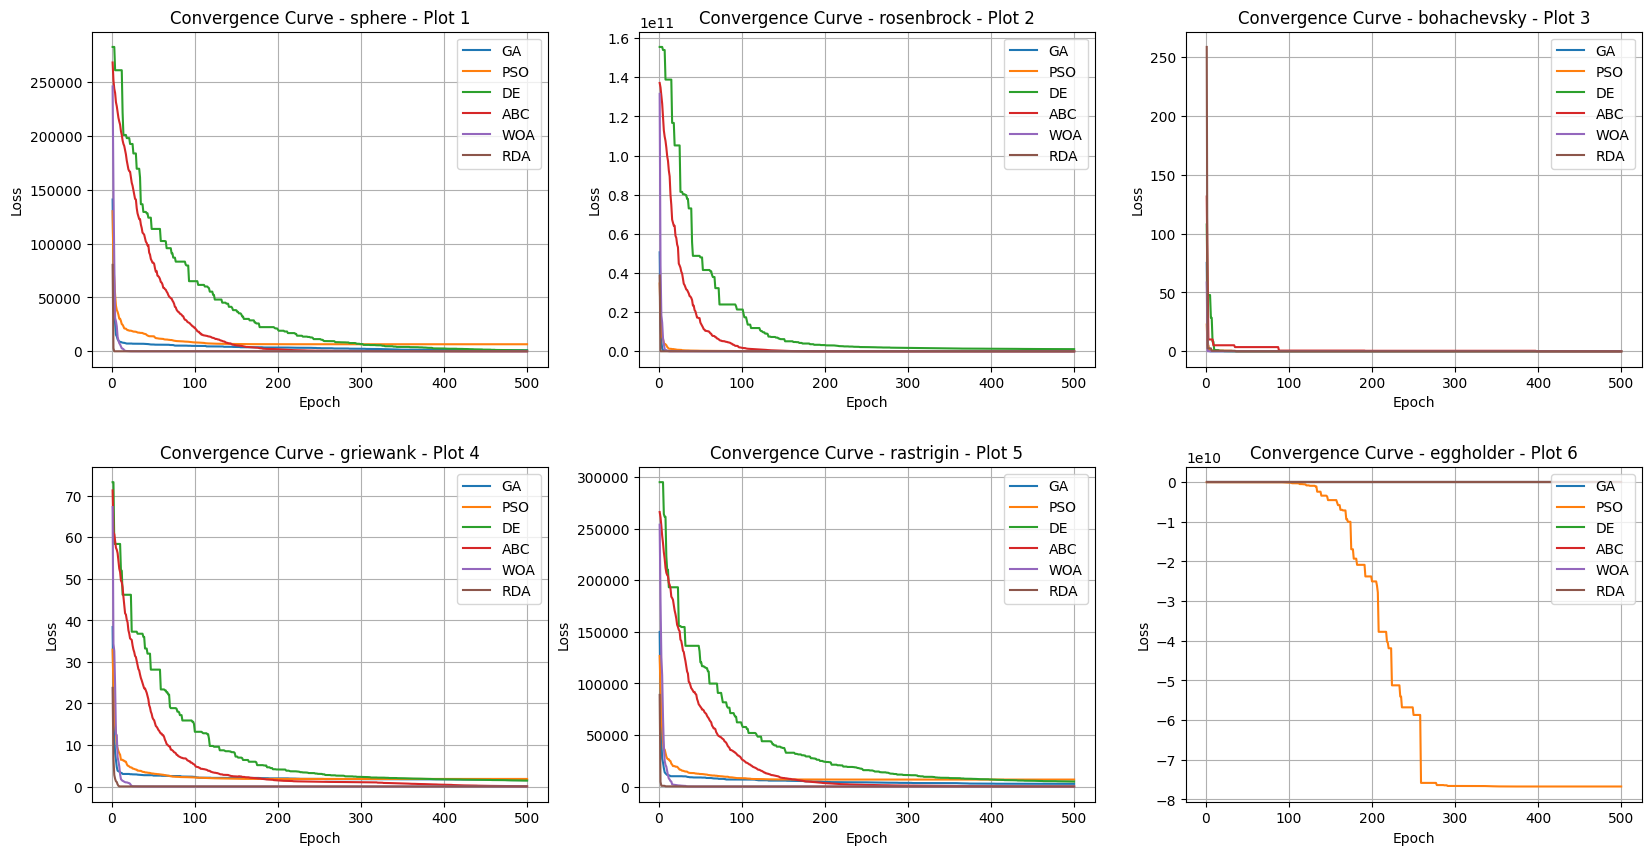

In [ ]:

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
func = ["sphere", "rosenbrock", "bohachevsky", "griewank", "rastrigin", "eggholder"]
for i in range(2):
    for j in range(3):
        ax = axes[i][j]
        ax.plot(range(1, MaxIt + 1), ga_loss_train[i*3+j], label="GA")
        ax.plot(range(1, MaxIt + 1), pso_loss_train[i*3+j], label="PSO")
        ax.plot(range(1, MaxIt + 1), de_loss_train[i*3+j], label="DE")
        ax.plot(range(1, MaxIt + 1), abc_loss_train[i*3+j], label="ABC")
        ax.plot(range(1, MaxIt + 1), woa_loss_train[i*3+j], label="WOA")
        ax.plot(range(1, MaxIt + 1), rda_loss_train[i*3+j], label="RDA")

        plt.subplots_adjust(hspace=0.3)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Convergence Curve - {func[i*3+j]} - Plot {i*3+j+1}")
        # ax.set_title('Manual y', y=1.0, pad=-14)
        ax.grid(True)
        ax.legend(loc="upper right")